In [217]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.utils import resample

# Classifiers:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

Load data, reshape X, and split into training, testing and validation data

In [218]:
y = np.load('MNIST-labels.npy')
X = np.load('MNIST-images.npy')

X = np.where(X<175,0,X) # replace noise in data with 0
X= X.reshape(X.shape[0], 576) #transform to vector

center_function = lambda x: x - x.mean()
X = center_function(X) # center the data
pca = PCA(n_components=75)
X = pca.fit_transform(X)

X_train,X_test_val,y_train,y_test_val = train_test_split(X, y, test_size=0.3, random_state = 42)
X_test,X_val,y_test,y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state = 42)

potential_models = pd.DataFrame(columns=['Classifier name','Accuracy score','F1 score','Classifier object'])

Resample

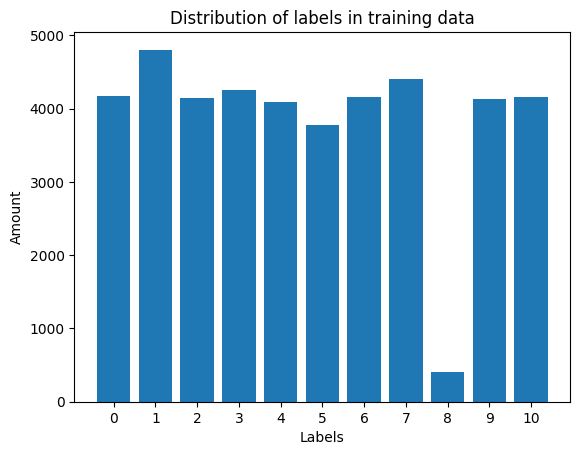

In [219]:
#create two different dataframe of majority and minority class 
X_majority = X_train[(y_train==3)] 
X_minority = X_train[(y_train==8)] 

X_remaining = X_train[(y_train!=3)]
y_remaining = y_train[(y_train!=3)]

# X_remaining = X_remaining[(y_remaining!=8)]
# y_remaining = y_remaining[(y_remaining!=8)]

average_amount = len(y_remaining)//9 # We create this so we can resample to the average amount of occorences of labels
# X_minority_upsampled = resample(X_minority, replace=True, n_samples= average_amount, random_state=42) 
X_majority_downsampled = resample(X_majority, replace=True, n_samples= average_amount, random_state=42) 
y_majority_downsampled = np.full(X_majority_downsampled.shape[0],3,dtype='int64')
# y_minority_upsampled = np.full(X_minority_upsampled.shape[0],8,dtype='int64')

# X_train= np.concatenate([X_remaining, X_minority_upsampled,X_majority_downsampled])
# y_train= np.concatenate([y_remaining, y_minority_upsampled,y_majority_downsampled])

X_train= np.concatenate([X_remaining, X_majority_downsampled])
y_train= np.concatenate([y_remaining, y_majority_downsampled])

rg = np.arange(0,11)
labels = pd.DataFrame(y_train).value_counts().sort_index().values
fig = plt.figure()
plt.xticks(rg)
plt.bar(rg,labels) # Using bar because histogram combined columns 9 and 10
plt.title('Distribution of labels in training data')
plt.xlabel('Labels')
plt.ylabel('Amount')
plt.show()

Function for evaltuating a given classifier. Currently we do this by checking the accuracy score and by plotting the confusion matrix 

In [220]:
def plot_c_matrix(clf, classifier_name,accuracy):
    disp = ConfusionMatrixDisplay.from_estimator(
            clf,
            X_val,
            y_val,
            display_labels=np.arange(0,11),
            cmap=plt.cm.Blues,
            include_values = False,
            normalize='true',
        )
    disp.ax_.set_title("Confusion matrix for " + str(classifier_name) +"  on validation data")
    plt.text(-4, 1, f'Acc: {str(round(accuracy,3))}', backgroundcolor = 'orange', fontsize = 10)
    plt.show()

def evaluate_classifier(clf,classifier_name):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_val)
    accuracy = metrics.accuracy_score(y_val,y_pred)
    f1_score = metrics.f1_score(y_val,y_pred, average='macro')
    
    plot_c_matrix(clf,classifier_name,accuracy)
    
    current_accuracy_dict = {
    'Classifier name' : [classifier_name],
    'Accuracy score' : [accuracy],
    'F1 score' : [f1_score],
    'Classifier object' : [clf]
    }
    current_accuracy_df = pd.DataFrame(current_accuracy_dict)
    return current_accuracy_df

Decision tree classifier:

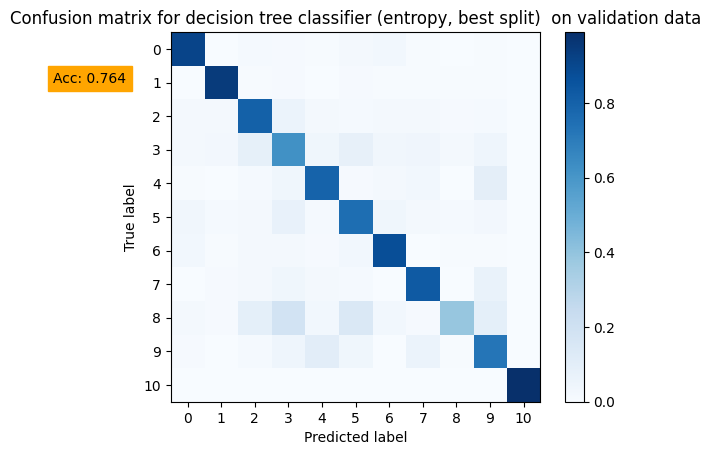

In [221]:
# dtc = DecisionTreeClassifier(splitter='random', random_state=1)
# dtc_accuracy = evaluate_classifier(dtc,"decision tree classifier (gini, random split)")
# potential_models = pd.concat([potential_models, dtc_accuracy],ignore_index=True)

# dtc = DecisionTreeClassifier(splitter='best', random_state=1)
# dtc_accuracy = evaluate_classifier(dtc,"decision tree classifier (gini, best split)")
# potential_models = pd.concat([potential_models, dtc_accuracy],ignore_index=True)

# dtc = DecisionTreeClassifier(splitter='random', criterion='entropy', random_state=1)
# dtc_accuracy = evaluate_classifier(dtc,"decision tree classifier (entropy, random split)")
# potential_models = pd.concat([potential_models, dtc_accuracy],ignore_index=True)

dtc = DecisionTreeClassifier(splitter='best', criterion='entropy', random_state=1)
dtc_accuracy = evaluate_classifier(dtc,"decision tree classifier (entropy, best split)")
potential_models = pd.concat([potential_models, dtc_accuracy],ignore_index=True)

K nearest neighbors:

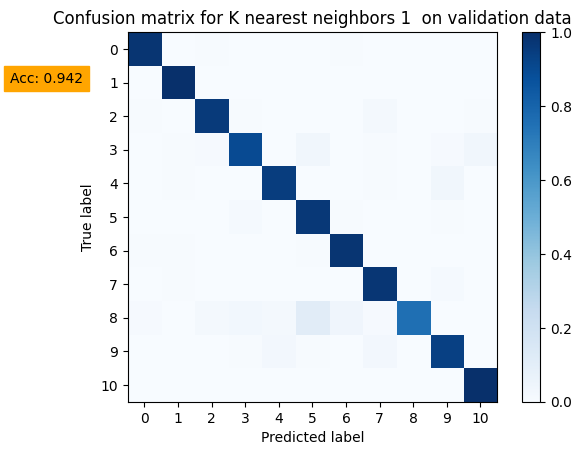

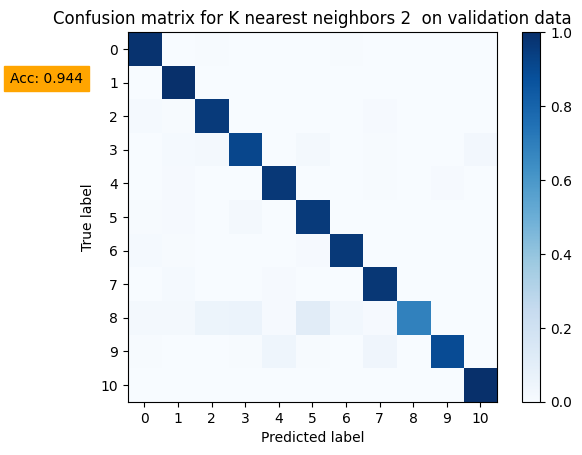

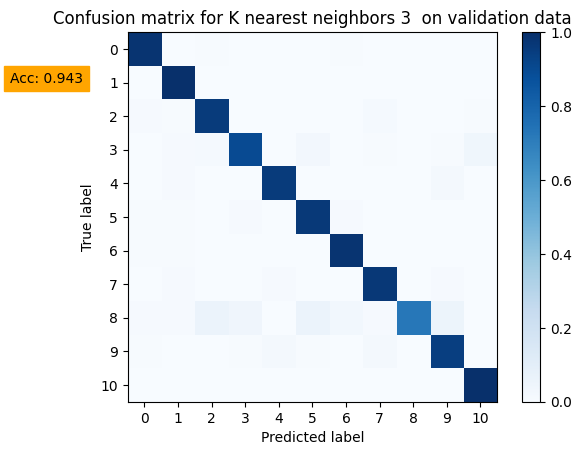

In [222]:
ks = [1,2,3]#,4,5,6,7,8,15,25]

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn_accuracy = evaluate_classifier(knn,'K nearest neighbors '+str(k))
    potential_models = pd.concat([potential_models,knn_accuracy],ignore_index=True)

In [223]:
# kernels = ['rbf']#['linear', 'poly', 'rbf', 'sigmoid']
# for kernel in kernels:
#     svm= SVC(random_state=1,kernel=kernel, class_weight='balanced',degree=1)
#     svm_accuracy = evaluate_classifier(svm, f'SVM balanced, kernel: {kernel}')
#     potential_models = pd.concat([potential_models,svm_accuracy],ignore_index=True)
    # svm= SVC(random_state=1,kernel=kernel,degree=1)
    # svm_accuracy = evaluate_classifier(svm, f'SVM, kernel: {kernel}')
    # potential_models = pd.concat([potential_models,svm_accuracy])

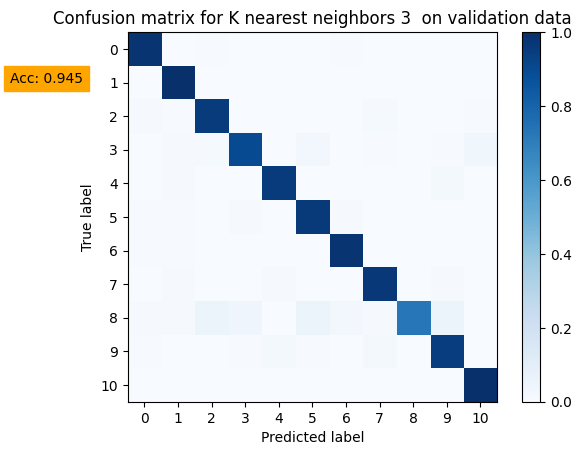

Classifier name                    K nearest neighbors 3
Accuracy score                                  0.942538
F1 score                                        0.932373
Classifier object    KNeighborsClassifier(n_neighbors=3)
Name: 3, dtype: object

In [229]:
potential_models = potential_models.sort_values(by="F1 score", ascending=False)
best_model = potential_models.iloc[0,:] # finds the classifier on the first row, the one with highest accuracy score
# potential_models#.iloc[4,:]['F1 score'].mean()
y_pred = best_model['Classifier object'].predict(X_test)
accuracy = metrics.accuracy_score(y_test,y_pred)
f1_score = metrics.f1_score(y_val,y_pred, average='macro')
plot_c_matrix(best_model['Classifier object'],best_model['Classifier name'],accuracy)
best_model